# Neural Network for Regression (LMA features to P,A coordinates)

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import RepeatedKFold

2022-03-10 19:51:17.745214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 19:51:17.745282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

In [2]:
#dataset = pd.read_csv('datasets/pa/LMA_DATA.csv')
#dataset = pd.read_csv('datasets/pa/Fs_B_LMA_DATA.csv')

dataset = pd.read_csv('datasets/pa/Fs_LMA_DATA_EXTRA.csv')

### Split into Test and Train data

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

No Training Samples: 45087
No Test Samples: 11272


### Split Features from Targets

In [4]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)

In [5]:
train_X.head()

avg_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
5770            0.380282                 0.661481                 0.693188   
20189           0.760466                 0.506470                 0.499213   
55768           0.580429                 0.168741                 0.465727   
5563            0.473783                 0.286455                 0.248704   
53047           0.815654                 0.545759                 0.515166   

       avg_feet_distance  avg_l_hand_chest_distance  \
5770            0.369381                   0.480609   
20189           0.280216                   0.567541   
55768           0.278130                   0.418851   
5563            0.449423                   0.480491   
53047           0.417240                   0.429151   

       avg_r_hand_chest_distance  avg_l_elbow_hip_distance  \
5770                    0.458428                  0.432211   
20189                   0.307238                  0.443042   
55768                   0.543607                  0.287841   
5563                    0.461131                  0.361082   
53047                   0.430379                  0.412061   

       avg_r_elbow_hip_distance  avg_chest_pelvis_distance  \
5770                   0.406739                   0.286151   
20189                  0.275669                   0.286151   
55768                  0.427787                   0.286151   
5563                   0.343791                   0.286151   
53047                  0.387947                   0.286151   

       avg_neck_chest_distance  ...  avg_pelvis_velocity_y  \
5770                  0.278481  ...              -0.032571   
20189                 0.278833  ...               0.148304   
55768                 0.267957  ...               0.055718   
5563                  0.278724  ...               0.286956   
53047                 0.277062  ...              -0.268965   

       avg_pelvis_velocity_z  avg_l_foot_velocity_x  avg_l_foot_velocity_y  \
5770                0.463787               0.008890               0.521765   
20189              -0.986957               0.107026              -0.060120   
55768              -0.386061              -0.208628               1.608111   
5563                0.203860              -0.085325               0.126640   
53047               0.362865              -0.787257               1.232325   

       avg_l_foot_velocity_z  avg_r_foot_velocity_x  avg_r_foot_velocity_y  \
5770               -0.203105               0.008890               0.521765   
20189               0.487608               0.107026              -0.060120   
55768               1.892997              -0.512417              -0.950072   
5563                0.158180              -0.085325               0.126640   
53047               1.885969               0.323288               0.566038   

       avg_r_foot_velocity_z  avg_upper_body_volume  avg_distance_traveled  
5770               -0.203105               0.051152               0.004335  
20189               0.487608               0.043785               0.010320  
55768              -0.566143               0.027890               0.002431  
5563                0.158180               0.030401               0.002548  
53047              -2.243664               0.055453               0.003610  

[5 rows x 33 columns]

In [6]:
train_y.head()

EMOTION_P  EMOTION_A
5770       -0.35        0.7
20189      -0.35        0.7
55768      -0.85       -0.1
5563       -0.50        0.6
53047       0.50        0.7

In [7]:
train_X.describe().transpose()[['mean', 'std']]

mean           std
avg_hand_distance          0.529250  2.858826e-01
avg_l_hand_hip_distance    0.368487  1.767053e-01
avg_r_hand_hip_distance    0.384095  1.830527e-01
avg_feet_distance          0.338780  1.578916e-01
avg_l_hand_chest_distance  0.433375  1.218224e-01
avg_r_hand_chest_distance  0.435605  1.203586e-01
avg_l_elbow_hip_distance   0.342878  8.884460e-02
avg_r_elbow_hip_distance   0.348284  8.796934e-02
avg_chest_pelvis_distance  0.286151  7.207276e-10
avg_neck_chest_distance    0.277053  3.783007e-03
avg_neck_rotation_w       -0.006553  1.122287e-01
avg_neck_rotation_x       -0.044965  3.232766e-01
avg_neck_rotation_y       -0.073788  1.523782e-01
avg_neck_rotation_z        0.881896  2.507139e-01
avg_pelvis_rotation_w     -0.008579  8.910255e-02
avg_pelvis_rotation_x     -0.045808  3.302284e-01
avg_pelvis_rotation_y     -0.067394  1.271939e-01
avg_pelvis_rotation_z      0.888927  2.445222e-01
std_l_hand_position        0.946554  9.527397e-01
std_r_hand_position        0.976579  9.857990e-01
avg_l_forearm_velocity     0.028861  1.687643e+00
avg_r_forearm_velocity     0.032204  1.709835e+00
avg_pelvis_velocity_x      0.005840  3.695934e-01
avg_pelvis_velocity_y     -0.002192  2.586952e-01
avg_pelvis_velocity_z      0.002865  3.563536e-01
avg_l_foot_velocity_x      0.012743  9.709588e-01
avg_l_foot_velocity_y      0.000351  1.028966e+00
avg_l_foot_velocity_z     -0.007952  1.165969e+00
avg_r_foot_velocity_x      0.003867  9.121743e-01
avg_r_foot_velocity_y     -0.014228  1.061643e+00
avg_r_foot_velocity_z     -0.002313  1.210872e+00
avg_upper_body_volume      0.035811  1.284636e-02
avg_distance_traveled      0.003116  3.543725e-03

### Normalize Data

In [8]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_X))

2022-03-10 19:51:57.070678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 19:51:57.070951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-10 19:51:57.071045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-10 19:51:57.071113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-10 19:51:57.071209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [9]:
print(normalizer.mean.numpy())

[[ 5.2924943e-01  3.6848739e-01  3.8409463e-01  3.3877978e-01
   4.3337458e-01  4.3560424e-01  3.4287751e-01  3.4828344e-01
   2.8615117e-01  2.7705243e-01 -6.5531838e-03 -4.4965312e-02
  -7.3787861e-02  8.8189656e-01 -8.5787745e-03 -4.5807511e-02
  -6.7394182e-02  8.8892668e-01  9.4655275e-01  9.7657913e-01
   2.8861398e-02  3.2204371e-02  5.8395267e-03 -2.1922518e-03
   2.8645722e-03  1.2742929e-02  3.5076356e-04 -7.9521555e-03
   3.8666967e-03 -1.4228471e-02 -2.3128937e-03  3.5810597e-02
   3.1155969e-03]]


In [10]:
first = np.array(train_X[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 0.38  0.66  0.69  0.37  0.48  0.46  0.43  0.41  0.29  0.28  0.23 -0.27
  -0.03  0.94  0.17 -0.28 -0.03  0.94  0.67  0.86  0.34  0.17 -0.06 -0.03
   0.46  0.01  0.52 -0.2   0.01  0.52 -0.2   0.05  0.  ]]

Normalized: [[-0.52  1.66  1.69  0.19  0.39  0.19  1.01  0.66 -0.6   0.38  2.1  -0.68
   0.27  0.21  2.06 -0.71  0.31  0.22 -0.29 -0.12  0.18  0.08 -0.17 -0.12
   1.29 -0.    0.51 -0.17  0.01  0.5  -0.17  1.19  0.34]]


## Create Model

### Define Model Layers

In [11]:
# "Usually it's a good practice to apply following formula in order to find out the total number of hidden layers needed." - https://stackoverflow.com/questions/49008074/how-to-create-a-neural-network-for-regression

# Nh = Ns/(α∗ (Ni + No))
# where:
#      Ni = number of input neurons.
#      No = number of output neurons.
#      Ns = number of samples in training data set.
#      α = an arbitrary scaling factor usually 2-10.
 
# Nh = 34431 / (5 * (29 + 2)) +-= 230

def build_and_compile_model(norm):
    model = keras.Sequential([
                norm,
        
                layers.Dense(32, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
        
                layers.Dense(2)
            ])

    
    model.compile(loss='mean_absolute_error',optimizer='adam') # Using MAE
    #model.compile(loss='mean_squared_error', optimizer='adam') # Using MSE
    
    return model

### Build Model

In [12]:
model = build_and_compile_model(normalizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 33)               67        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 5,413
Trainable params: 5,346
Non-trainable params: 67
_____________________________________________________

## Train Model

In [13]:
%%time
history = model.fit(
    train_X,
    train_y,
    validation_split=0.2,
    epochs=128, batch_size = 16, 
    verbose=2)

Epoch 1/128
2255/2255 - 3s - loss: 0.3520 - val_loss: 0.3318 - 3s/epoch - 1ms/step
Epoch 2/128
2255/2255 - 2s - loss: 0.3244 - val_loss: 0.3222 - 2s/epoch - 806us/step
Epoch 3/128
2255/2255 - 2s - loss: 0.3136 - val_loss: 0.3141 - 2s/epoch - 809us/step
Epoch 4/128
2255/2255 - 2s - loss: 0.3064 - val_loss: 0.3084 - 2s/epoch - 814us/step
Epoch 5/128
2255/2255 - 2s - loss: 0.3010 - val_loss: 0.3019 - 2s/epoch - 811us/step
Epoch 6/128
2255/2255 - 2s - loss: 0.2965 - val_loss: 0.3025 - 2s/epoch - 812us/step
Epoch 7/128
2255/2255 - 2s - loss: 0.2928 - val_loss: 0.2982 - 2s/epoch - 813us/step
Epoch 8/128
2255/2255 - 2s - loss: 0.2891 - val_loss: 0.2996 - 2s/epoch - 812us/step
Epoch 9/128
2255/2255 - 2s - loss: 0.2864 - val_loss: 0.2968 - 2s/epoch - 815us/step
Epoch 10/128
2255/2255 - 2s - loss: 0.2845 - val_loss: 0.2924 - 2s/epoch - 811us/step
Epoch 11/128
2255/2255 - 2s - loss: 0.2821 - val_loss: 0.2923 - 2s/epoch - 811us/step
Epoch 12/128
2255/2255 - 2s - loss: 0.2800 - val_loss: 0.2915 - 2

Epoch 97/128
2255/2255 - 2s - loss: 0.2418 - val_loss: 0.2769 - 2s/epoch - 807us/step
Epoch 98/128
2255/2255 - 2s - loss: 0.2411 - val_loss: 0.2790 - 2s/epoch - 821us/step
Epoch 99/128
2255/2255 - 2s - loss: 0.2409 - val_loss: 0.2763 - 2s/epoch - 806us/step
Epoch 100/128
2255/2255 - 2s - loss: 0.2406 - val_loss: 0.2798 - 2s/epoch - 816us/step
Epoch 101/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2755 - 2s/epoch - 814us/step
Epoch 102/128
2255/2255 - 2s - loss: 0.2406 - val_loss: 0.2765 - 2s/epoch - 828us/step
Epoch 103/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2745 - 2s/epoch - 850us/step
Epoch 104/128
2255/2255 - 2s - loss: 0.2404 - val_loss: 0.2781 - 2s/epoch - 813us/step
Epoch 105/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2759 - 2s/epoch - 822us/step
Epoch 106/128
2255/2255 - 2s - loss: 0.2405 - val_loss: 0.2763 - 2s/epoch - 808us/step
Epoch 107/128
2255/2255 - 2s - loss: 0.2397 - val_loss: 0.2766 - 2s/epoch - 811us/step
Epoch 108/128
2255/2255 - 2s - loss: 0.2396 - 

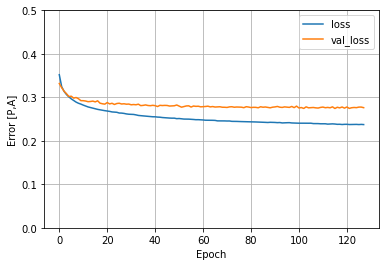

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, .5])
    plt.xlabel('Epoch')
    plt.ylabel('Error [P,A]')
    plt.legend()
    plt.grid(True)


plot_loss(history)

## Test Model

### Test

In [15]:
test_results = model.evaluate(test_X, test_y, verbose=2)
print("Mean Absolute Error:",test_results)

353/353 - 0s - loss: 0.2719 - 220ms/epoch - 624us/step
Mean Absolute Error: 0.27186521887779236


### Predictions

In [16]:
test_y.head()

EMOTION_P  EMOTION_A
2        -0.5        0.6
9        -0.5        0.6
10       -0.5        0.6
12       -0.5        0.6
16       -0.5        0.6

In [17]:
test_predictions = model.predict(test_X)

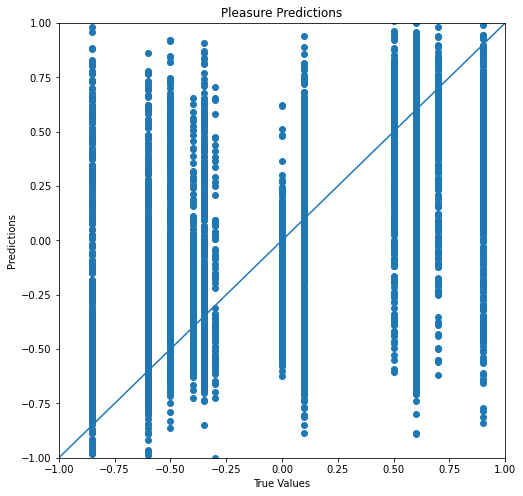

In [18]:
test_y_p = test_y.iloc[:,0]
pred_y_p = test_predictions[:,0]

fig = plt.figure(figsize=[8,8])

plt.scatter(test_y_p, pred_y_p)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Pleasure Predictions')

lims = [-1,1]
plt.xlim(lims)
plt.ylim(lims)

plt.plot(lims, lims)

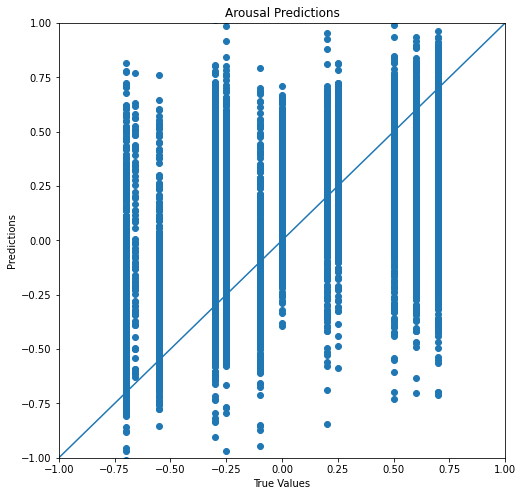

In [19]:
test_y_a = test_y.iloc[:,1]
pred_y_a = test_predictions[:,1]

fig = plt.figure(figsize=[8,8])

plt.scatter(test_y_a, pred_y_a)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Arousal Predictions')

lims = [-1,1]
plt.xlim(lims)
plt.ylim(lims)

plt.plot(lims, lims)

### Prediction

In [20]:
row=test_X.iloc[3]

newX = np.asarray([row])
print(newX)

yhat = model.predict(newX)
print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % yhat[0])

[[ 4.29294321e-01  3.06416764e-01  1.90160499e-01  4.80217455e-01
   4.81940802e-01  3.92710381e-01  3.68086612e-01  2.79621814e-01
   2.86151000e-01  2.78543929e-01  1.46260049e-03  7.27718893e-02
  -1.24973131e-01  9.88677098e-01 -7.23215648e-03  7.74506342e-02
  -7.46573787e-02  9.93415262e-01  3.44755140e-01  2.35700501e-01
   2.43901109e-01 -1.90304534e+00  1.11720574e-01  1.17148491e-02
  -2.64487607e-01 -3.25672018e-01 -1.32798951e+00 -1.13553977e-01
  -3.25672018e-01 -1.32798951e+00 -1.13553977e-01  2.75070287e-02
   2.29849149e-03]]
Real: [-0.5  0.6]
Predicted: [-0.52534443  0.1486804 ]


In [21]:
row=test_X.iloc[150]

newX = np.asarray([row])
print(newX)

yhat = model.predict(newX)
print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % yhat[0])

[[ 1.17215946e-01  3.61241095e-01  3.99839017e-01  4.36527563e-01
   2.25056134e-01  2.50486207e-01  2.13999571e-01  2.25460328e-01
   2.86151000e-01  2.78802821e-01 -4.47469565e-02 -1.97556939e-02
  -1.22498981e-01  9.91259681e-01 -3.79469484e-02 -1.91014097e-02
  -9.71441635e-02  9.94360778e-01  1.50873400e+00  1.53570480e+00
   5.10256963e-03  2.48060947e-02 -6.57138458e-02  3.51885611e-03
   3.30361134e-02  1.60708801e-02 -3.23744358e-02  6.02535890e-02
   1.60708801e-02 -3.23744358e-02  6.02535890e-02  3.09335762e-02
   5.35708106e-04]]
Real: [-0.5  0.6]
Predicted: [-0.37035128  0.5560564 ]


In [22]:
row=test_X.iloc[69]

newX = np.asarray([row])
print(newX)

yhat = model.predict(newX)
print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % yhat[0])

[[ 7.45094044e-01  3.08864935e-01  5.89613759e-01  2.16829686e-01
   4.88945356e-01  5.00097549e-01  3.68079471e-01  4.04840912e-01
   2.86151000e-01  2.78836833e-01 -4.74951927e-02  1.28751507e-02
  -1.02237442e-02  9.98701594e-01 -3.35488704e-02  1.02280769e-02
  -2.56976120e-02  9.99019439e-01  8.40703464e-01  8.31786194e-01
   7.28529193e-03 -1.12519885e+00 -4.73639152e-02  3.69714237e-03
  -3.61404533e-02 -3.79055102e-02  1.92132258e-01 -1.37202153e-01
  -3.79055102e-02  1.92132258e-01 -1.37202153e-01  3.92774494e-02
   3.67095874e-04]]
Real: [-0.5  0.6]
Predicted: [-0.0444088 -0.0207414]


# Gradient Boosting (LMA features to P,A coordinates)

## Imports

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
import tensorflow as tf

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor

## Load Data

In [113]:
dataset = pd.read_csv('datasets/pa/Fs_B_N_LMA_DATA.csv')

### Split into Test and Train data

In [114]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

No Training Samples: 8000
No Test Samples: 2000


### Split Features from Targets

In [115]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

In [116]:
train_X.head()

avg_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
6252           0.182161                 0.239957                 0.073864   
4684           0.445825                 0.270398                 0.307184   
1731           0.630929                 0.655890                 0.246729   
4742           0.713392                 0.546526                 0.452078   
4521           0.403415                 0.269620                 0.282995   

      avg_feet_distance  avg_l_hand_chest_distance  avg_r_hand_chest_distance  \
6252           0.239951                   0.627903                   0.481206   
4684           0.540458                   0.629404                   0.480568   
1731           0.060113                   0.653721                   0.612517   
4742           0.520810                   0.801025                   0.734590   
4521           0.051448                   0.644198                   0.634451   

      avg_l_elbow_hip_distance  avg_r_elbow_hip_distance  \
6252                  0.502666                  0.344620   
4684                  0.497964                  0.556971   
1731                  0.599840                  0.526427   
4742                  0.773689                  0.665912   
4521                  0.521853                  0.554992   

      avg_chest_pelvis_distance  avg_neck_chest_distance  ...  \
6252                   0.415943                 0.979307  ...   
4684                   0.355507                 0.977475  ...   
1731                   0.305967                 0.996776  ...   
4742                   0.339651                 0.989962  ...   
4521                   0.314383                 0.999728  ...   

      avg_pelvis_velocity_y  avg_pelvis_velocity_z  avg_l_foot_velocity_x  \
6252               0.581273               0.457494               0.579834   
4684               0.701403               0.453512               0.567967   
1731               0.574805               0.494450               0.583849   
4742               0.532673               0.334498               0.570885   
4521               0.584685               0.488869               0.583202   

      avg_l_foot_velocity_y  avg_l_foot_velocity_z  avg_r_foot_velocity_x  \
6252               0.408163               0.508905               0.625058   
4684               0.471092               0.594918               0.640870   
1731               0.422701               0.483744               0.630963   
4742               0.344419               0.486102               0.629931   
4521               0.422638               0.485936               0.630273   

      avg_r_foot_velocity_y  avg_r_foot_velocity_z  avg_upper_body_volume  \
6252               0.410921               0.481715               0.206246   
4684               0.502866               0.438463               0.529884   
1731               0.421293               0.454491               0.467607   
4742               0.353288               0.494141               0.682069   
4521               0.421230               0.457467               0.350990   

      avg_distance_traveled  
6252               0.093821  
4684               0.154873  
1731               0.005886  
4742               0.130044  
4521               0.006148  

[5 rows x 33 columns]

In [117]:
train_y.head()

EMOTION_P  EMOTION_A
6252        0.1       -0.7
4684        0.7        0.2
1731       -0.5        0.6
4742        0.7        0.2
4521        0.6        0.5

In [118]:
train_X.describe().transpose()[['mean', 'std']]

mean       std
avg_hand_distance          0.403083  0.223347
avg_l_hand_hip_distance    0.337277  0.200253
avg_r_hand_hip_distance    0.350649  0.198675
avg_feet_distance          0.246535  0.107873
avg_l_hand_chest_distance  0.603496  0.160886
avg_r_hand_chest_distance  0.589745  0.170321
avg_l_elbow_hip_distance   0.514783  0.171863
avg_r_elbow_hip_distance   0.543706  0.171387
avg_chest_pelvis_distance  0.323467  0.062589
avg_neck_chest_distance    0.973500  0.048300
avg_neck_rotation_w        0.419621  0.071443
avg_neck_rotation_x        0.439855  0.151033
avg_neck_rotation_y        0.422771  0.083809
avg_neck_rotation_z        0.942024  0.131383
avg_pelvis_rotation_w      0.474726  0.059747
avg_pelvis_rotation_x      0.432543  0.152147
avg_pelvis_rotation_y      0.467433  0.078508
avg_pelvis_rotation_z      0.945587  0.119850
std_l_hand_position        0.372793  0.176933
std_r_hand_position        0.370799  0.183757
avg_l_forearm_velocity     0.508280  0.069435
avg_r_forearm_velocity     0.431091  0.041335
avg_pelvis_velocity_x      0.548084  0.099633
avg_pelvis_velocity_y      0.574691  0.075237
avg_pelvis_velocity_z      0.494783  0.074325
avg_l_foot_velocity_x      0.583680  0.020146
avg_l_foot_velocity_y      0.422088  0.032834
avg_l_foot_velocity_z      0.486823  0.046077
avg_r_foot_velocity_x      0.629970  0.019218
avg_r_foot_velocity_y      0.421198  0.031831
avg_r_foot_velocity_z      0.457458  0.063123
avg_upper_body_volume      0.436529  0.210297
avg_distance_traveled      0.060930  0.070738

## Define Model

In [121]:
model_p = GradientBoostingRegressor()
model_a = GradientBoostingRegressor()

## Train Model

In [122]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

### Pleasure Regression

In [123]:
n_scores = cross_val_score(model_p, train_X, train_y_p, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.236 (0.007)


In [124]:
model_p.fit(train_X, train_y_p)

GradientBoostingRegressor()

### Arousal Regression

In [125]:
n_scores = cross_val_score(model_a, train_X, train_y_a, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.240 (0.006)


In [126]:
model_a.fit(train_X, train_y_a)

GradientBoostingRegressor()

## Test Model

### Prediction

In [127]:
row=test_X.iloc[0]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p, y_a])

Real: [-0.35  0.7 ]
Predicted: [array([-0.16072887]), array([0.50489924])]


/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [129]:
row=test_X.iloc[150]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p, y_a])

Real: [-0.35  0.7 ]
Predicted: [array([-0.25354781]), array([0.40621777])]


/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [130]:
row=test_X.iloc[69]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p, y_a])

Real: [-0.35  0.7 ]
Predicted: [array([-0.27337685]), array([0.32014121])]


/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/ds/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


# XGBRegression (LMA features to P,A coordinates)

## Imports

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold

import xgboost as xgb

xgb.set_config(verbosity=2)

from sklearn.metrics import mean_squared_error

/home/ds/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load Data

In [24]:
#dataset = pd.read_csv('datasets/pa/Fs_B_N_LMA_DATA.csv')
#dataset = pd.read_csv('datasets/pa/Fs_N_LMA_DATA.csv')
dataset = pd.read_csv('datasets/pa/Fs_N_LMA_DATA_EXTRA.csv')

### Split into Test and Train data

In [25]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

No Training Samples: 45087
No Test Samples: 11272


### Split Features from Targets

In [26]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

In [27]:
train_X.head()

avg_hand_distance  avg_l_hand_hip_distance  avg_r_hand_hip_distance  \
5770            0.262334                 0.662568                 0.696583   
20189           0.531666                 0.499619                 0.491083   
55768           0.404123                 0.144595                 0.455608   
5563            0.328572                 0.268337                 0.225690   
53047           0.570762                 0.540919                 0.507984   

       avg_feet_distance  avg_l_hand_chest_distance  \
5770            0.241384                   0.630144   
20189           0.182074                   0.747718   
55768           0.180686                   0.546617   
5563            0.294625                   0.629984   
53047           0.273218                   0.560548   

       avg_r_hand_chest_distance  avg_l_elbow_hip_distance  \
5770                    0.594538                  0.681151   
20189                   0.387772                  0.699997   
55768                   0.711027                  0.429951   
5563                    0.598234                  0.557388   
53047                   0.556178                  0.646091   

       avg_r_elbow_hip_distance  avg_chest_pelvis_distance  \
5770                   0.629491                   0.257159   
20189                  0.397462                   0.256635   
55768                  0.666752                   0.272435   
5563                   0.518056                   0.264650   
53047                  0.596224                   0.260777   

       avg_neck_chest_distance  ...  avg_pelvis_velocity_y  \
5770                  0.996101  ...               0.473326   
20189                 0.999420  ...               0.492880   
55768                 0.896752  ...               0.482871   
5563                  0.998397  ...               0.507869   
53047                 0.982706  ...               0.447770   

       avg_pelvis_velocity_z  avg_l_foot_velocity_x  avg_l_foot_velocity_y  \
5770                0.539095               0.590923               0.633511   
20189               0.357735               0.592764               0.617945   
55768               0.432854               0.586842               0.662572   
5563                0.506601               0.589155               0.622941   
53047               0.526478               0.575987               0.652520   

       avg_l_foot_velocity_z  avg_r_foot_velocity_x  avg_r_foot_velocity_y  \
5770                0.331921               0.448977               0.506205   
20189               0.345391               0.450799               0.496437   
55768               0.372798               0.439296               0.481497   
5563                0.338966               0.447227               0.499572   
53047               0.372661               0.454815               0.506949   

       avg_r_foot_velocity_z  avg_upper_body_volume  avg_distance_traveled  
5770                0.533892               0.634425               0.055723  
20189               0.548976               0.533730               0.132637  
55768               0.525963               0.316449               0.031250  
5563                0.541782               0.350779               0.032754  
53047               0.489328               0.693218               0.046396  

[5 rows x 33 columns]

In [28]:
train_y.head()

EMOTION_P  EMOTION_A
5770       -0.35        0.7
20189      -0.35        0.7
55768      -0.85       -0.1
5563       -0.50        0.6
53047       0.50        0.7

In [29]:
train_X.describe().transpose()[['mean', 'std']]

mean       std
avg_hand_distance          0.367866  0.202526
avg_l_hand_hip_distance    0.354570  0.185754
avg_r_hand_hip_distance    0.369125  0.193929
avg_feet_distance          0.221029  0.105025
avg_l_hand_chest_distance  0.566260  0.164762
avg_r_hand_chest_distance  0.563325  0.164601
avg_l_elbow_hip_distance   0.525713  0.154588
avg_r_elbow_hip_distance   0.526010  0.155729
avg_chest_pelvis_distance  0.268310  0.023227
avg_neck_chest_distance    0.982620  0.035712
avg_neck_rotation_w        0.476252  0.071978
avg_neck_rotation_x        0.438399  0.173934
avg_neck_rotation_y        0.443365  0.086577
avg_neck_rotation_z        0.921091  0.167569
avg_pelvis_rotation_w      0.518902  0.059338
avg_pelvis_rotation_x      0.437719  0.177642
avg_pelvis_rotation_y      0.421655  0.074516
avg_pelvis_rotation_z      0.925631  0.163795
std_l_hand_position        0.123915  0.127292
std_r_hand_position        0.126052  0.128747
avg_l_forearm_velocity     0.523746  0.065931
avg_r_forearm_velocity     0.466473  0.061265
avg_pelvis_velocity_x      0.595003  0.038377
avg_pelvis_velocity_y      0.476610  0.027967
avg_pelvis_velocity_z      0.481474  0.044548
avg_l_foot_velocity_x      0.590995  0.018215
avg_l_foot_velocity_y      0.619563  0.027526
avg_l_foot_velocity_z      0.335727  0.022738
avg_r_foot_velocity_x      0.448884  0.016939
avg_r_foot_velocity_y      0.497207  0.017822
avg_r_foot_velocity_z      0.538277  0.026444
avg_upper_body_volume      0.424719  0.175602
avg_distance_traveled      0.040045  0.045548

## Define Model

In [45]:
xgbr = xgb.XGBRegressor(verbosity=0) 


model_p = xgb.XGBRegressor(
                    n_estimators=2000, learning_rate=0.05, max_depth=10, min_child_weight=11, 
                    subsample=1, colsample_bytree=1, objective="reg:linear"
                )

model_a = xgb.XGBRegressor(
                    n_estimators=2000, learning_rate=0.05, max_depth=10, min_child_weight=11, 
                    subsample=1, colsample_bytree=1, objective="reg:linear"
                )

## Train Model

### Pleasure Regression

In [46]:
model_p.fit(train_X, train_y_p)

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:08:15] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 752 extra nodes, 0 pruned nodes, max_depth=10
[20:08:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 760 extra nodes, 0 pruned nodes, max_depth=10
[20:08:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 768 extra nodes, 0 pruned nodes, max_depth=10
[20:08:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 760 extra nodes, 0 pruned nodes, max_depth=10
[20:08:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 768 extra nodes, 0 pruned nodes, max_depth=10
[20:08:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 868 extra nodes, 0 pruned nodes, max_depth=10
[20:08:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 846 extra nodes, 0 pruned nodes, max_depth=10
[20:08:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 744 ext

[20:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=10
[20:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 520 extra nodes, 0 pruned nodes, max_depth=10
[20:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[20:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[20:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=10
[20:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=10
[20:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 878 extra nodes, 0 pruned nodes, max_depth=10
[20:08:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[20:08:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra n

[20:08:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 628 extra nodes, 0 pruned nodes, max_depth=10
[20:08:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=10
[20:08:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=10
[20:08:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 602 extra nodes, 0 pruned nodes, max_depth=10
[20:08:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=10
[20:08:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[20:08:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[20:08:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 624 extra nodes, 0 pruned nodes, max_depth=10
[20:08:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 400 extra n

[20:08:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=10
[20:08:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=10
[20:08:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=10
[20:08:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[20:08:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 838 extra nodes, 0 pruned nodes, max_depth=10
[20:08:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[20:08:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=10
[20:08:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=10
[20:08:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 388 extra nod

[20:08:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[20:08:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=10
[20:08:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[20:08:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=10
[20:08:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=10
[20:08:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[20:08:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=10
[20:08:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 678 extra nodes, 0 pruned nodes, max_depth=10
[20:08:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 440 extra no

[20:09:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 590 extra nodes, 0 pruned nodes, max_depth=10
[20:09:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[20:09:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 518 extra nodes, 0 pruned nodes, max_depth=10
[20:09:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=10
[20:09:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=10
[20:09:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[20:09:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[20:09:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=10
[20:09:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra no

[20:09:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[20:09:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 642 extra nodes, 0 pruned nodes, max_depth=10
[20:09:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[20:09:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=10
[20:09:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[20:09:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=10
[20:09:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=10
[20:09:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=10
[20:09:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra n

[20:09:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=10
[20:09:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[20:09:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=10
[20:09:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 608 extra nodes, 0 pruned nodes, max_depth=10
[20:09:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 518 extra nodes, 0 pruned nodes, max_depth=10
[20:09:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=10
[20:09:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=10
[20:09:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=10
[20:09:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra n

[20:09:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[20:09:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 518 extra nodes, 0 pruned nodes, max_depth=10
[20:09:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 528 extra nodes, 0 pruned nodes, max_depth=10
[20:09:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=10
[20:09:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[20:09:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[20:09:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[20:09:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[20:09:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 524 extra n

[20:09:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[20:09:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[20:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=10
[20:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=10
[20:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=10
[20:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=10
[20:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=10
[20:09:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[20:09:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra no

[20:10:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 558 extra nodes, 0 pruned nodes, max_depth=10
[20:10:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 534 extra nodes, 0 pruned nodes, max_depth=10
[20:10:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=10
[20:10:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 590 extra nodes, 0 pruned nodes, max_depth=10
[20:10:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 534 extra nodes, 0 pruned nodes, max_depth=10
[20:10:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[20:10:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[20:10:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=10
[20:10:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 446 extra n

[20:10:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=10
[20:10:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[20:10:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=10
[20:10:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=10
[20:10:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=10
[20:10:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=10
[20:10:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=10
[20:10:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[20:10:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra n

[20:10:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=10
[20:10:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[20:10:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[20:10:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[20:10:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=10
[20:10:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=10
[20:10:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=10
[20:10:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=10
[20:10:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[20:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=10
[20:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=10
[20:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=10
[20:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[20:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[20:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=10
[20:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[20:10:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=10
[20:10:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra n

[20:10:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 716 extra nodes, 0 pruned nodes, max_depth=10
[20:10:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[20:10:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=10
[20:10:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=10
[20:10:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[20:10:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=10
[20:10:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=10
[20:10:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[20:10:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra n

[20:10:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=10
[20:10:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=10
[20:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[20:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=10
[20:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[20:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=10
[20:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=10
[20:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[20:10:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra n

[20:11:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=10
[20:11:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=10
[20:11:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[20:11:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[20:11:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=10
[20:11:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=10
[20:11:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=10
[20:11:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[20:11:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 416 extra no

[20:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=10
[20:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=10
[20:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[20:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[20:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=10
[20:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=10
[20:11:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=10
[20:11:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[20:11:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra n

[20:11:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[20:11:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=10
[20:11:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[20:11:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=10
[20:11:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[20:11:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[20:11:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[20:11:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[20:11:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra n

[20:11:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=10
[20:11:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[20:11:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=10
[20:11:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[20:11:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=10
[20:11:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=10
[20:11:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 482 extra nodes, 0 pruned nodes, max_depth=10
[20:11:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[20:11:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra no

[20:11:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[20:11:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=10
[20:11:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=10
[20:11:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=10
[20:11:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=10
[20:11:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=10
[20:11:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[20:11:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=10
[20:11:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra no

[20:12:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=10
[20:12:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=10
[20:12:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[20:12:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[20:12:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=10
[20:12:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=10
[20:12:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[20:12:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[20:12:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra n

[20:12:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[20:12:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[20:12:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=10
[20:12:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[20:12:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[20:12:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=10
[20:12:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=10
[20:12:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=10
[20:12:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra n

[20:12:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=10
[20:12:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[20:12:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[20:12:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[20:12:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[20:12:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[20:12:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=10
[20:12:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[20:12:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra n

[20:12:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=10
[20:12:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[20:12:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=10
[20:12:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[20:12:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=10
[20:12:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=10
[20:12:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=10
[20:12:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=10
[20:12:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra n

[20:12:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[20:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[20:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=10
[20:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=10
[20:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[20:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[20:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[20:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=10
[20:12:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra n

[20:12:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[20:12:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[20:12:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=10
[20:12:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[20:12:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=10
[20:12:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[20:12:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=10
[20:12:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=10
[20:12:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra no

[20:13:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=10
[20:13:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=10
[20:13:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=10
[20:13:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=10
[20:13:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[20:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=10
[20:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=10
[20:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=10
[20:13:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 496 extra n

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=11, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

### Arousal Regression

In [47]:
model_a.fit(train_X, train_y_a)

[20:13:19] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 840 extra nodes, 0 pruned nodes, max_depth=10
[20:13:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 864 extra nodes, 0 pruned nodes, max_depth=10
[20:13:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=10
[20:13:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 928 extra nodes, 0 pruned nodes, max_depth=10
[20:13:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 890 extra nodes, 0 pruned nodes, max_depth=10
[20:13:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 944 extra nodes, 0 pruned nodes, max_depth=10
[20:13:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 944 extra nodes, 0 pruned nodes, max_depth=10
[20:13:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 834 ext

[20:13:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 628 extra nodes, 0 pruned nodes, max_depth=10
[20:13:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=10
[20:13:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 570 extra nodes, 0 pruned nodes, max_depth=10
[20:13:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[20:13:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 876 extra nodes, 0 pruned nodes, max_depth=10
[20:13:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[20:13:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=10
[20:13:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 626 extra nodes, 0 pruned nodes, max_depth=10
[20:13:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 400 extra n

[20:13:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=10
[20:13:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[20:13:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[20:13:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=10
[20:13:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 768 extra nodes, 0 pruned nodes, max_depth=10
[20:13:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=10
[20:13:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=10
[20:13:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 700 extra nodes, 0 pruned nodes, max_depth=10
[20:13:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 400 extra n

[20:13:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[20:13:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=10
[20:13:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=10
[20:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[20:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 624 extra nodes, 0 pruned nodes, max_depth=10
[20:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 410 extra nodes, 0 pruned nodes, max_depth=10
[20:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=10
[20:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=10
[20:13:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 614 extra n

[20:14:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=10
[20:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=10
[20:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=10
[20:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[20:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[20:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=10
[20:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[20:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[20:14:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra n

[20:14:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[20:14:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[20:14:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[20:14:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[20:14:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[20:14:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[20:14:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 804 extra nodes, 0 pruned nodes, max_depth=10
[20:14:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[20:14:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 678 extra n

[20:14:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=10
[20:14:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=10
[20:14:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=10
[20:14:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=10
[20:14:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=10
[20:14:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=10
[20:14:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=10
[20:14:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=10
[20:14:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra n

[20:14:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[20:14:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=10
[20:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[20:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=10
[20:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=10
[20:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[20:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=10
[20:14:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[20:14:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra no

[20:14:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=10
[20:14:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=10
[20:14:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[20:14:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=10
[20:14:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=10
[20:14:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[20:14:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=10
[20:14:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[20:14:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra no

[20:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[20:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=10
[20:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=10
[20:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[20:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=10
[20:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=10
[20:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=10
[20:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=10
[20:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra no

[20:15:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=10
[20:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 522 extra nodes, 0 pruned nodes, max_depth=10
[20:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[20:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=10
[20:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[20:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 534 extra nodes, 0 pruned nodes, max_depth=10
[20:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=10
[20:15:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[20:15:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra n

[20:15:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[20:15:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=10
[20:15:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[20:15:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[20:15:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=10
[20:15:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=10
[20:15:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[20:15:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 702 extra nodes, 0 pruned nodes, max_depth=10
[20:15:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra no

[20:15:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=10
[20:15:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[20:15:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=10
[20:15:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=10
[20:15:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[20:15:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=10
[20:15:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=10
[20:15:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=10
[20:15:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 414 extra no

[20:15:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=10
[20:15:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=10
[20:15:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=10
[20:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=10
[20:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[20:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[20:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=10
[20:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=10
[20:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra n

[20:15:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=10
[20:15:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 822 extra nodes, 0 pruned nodes, max_depth=10
[20:15:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[20:15:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=10
[20:15:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=10
[20:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=10
[20:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[20:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[20:15:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 722 extra n

[20:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=10
[20:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=10
[20:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=10
[20:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[20:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[20:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=10
[20:16:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=10
[20:16:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[20:16:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra n

[20:16:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[20:16:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[20:16:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=10
[20:16:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[20:16:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=10
[20:16:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[20:16:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=10
[20:16:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[20:16:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 370 extra nod

[20:16:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=10
[20:16:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=10
[20:16:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[20:16:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[20:16:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[20:16:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=10
[20:16:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[20:16:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=10
[20:16:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 484 extra n

[20:16:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=10
[20:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[20:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[20:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=10
[20:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[20:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=10
[20:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=10
[20:16:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=10
[20:16:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra no

[20:16:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[20:16:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[20:16:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[20:16:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=10
[20:16:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=10
[20:16:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=10
[20:16:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=10
[20:16:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[20:16:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra no

[20:16:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=10
[20:16:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=10
[20:16:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[20:16:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=10
[20:16:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[20:16:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=10
[20:16:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=10
[20:16:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=10
[20:16:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 490 extra no

[20:17:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=10
[20:17:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=10
[20:17:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[20:17:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=10
[20:17:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=10
[20:17:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=10
[20:17:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=10
[20:17:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=10
[20:17:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 518 extra n

[20:17:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[20:17:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[20:17:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=10
[20:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[20:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=10
[20:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[20:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[20:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=10
[20:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra n

[20:17:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 516 extra nodes, 0 pruned nodes, max_depth=10
[20:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=10
[20:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=10
[20:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=10
[20:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[20:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=10
[20:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[20:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=10
[20:17:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 414 extra n

[20:17:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[20:17:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=10
[20:17:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 624 extra nodes, 0 pruned nodes, max_depth=10
[20:17:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[20:17:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[20:17:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[20:17:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=10
[20:17:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=10
[20:17:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 398 extra n

[20:17:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[20:17:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=10
[20:17:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[20:17:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=10
[20:17:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[20:17:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=10
[20:17:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=10
[20:17:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[20:17:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra n

[20:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=10
[20:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=10
[20:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=10
[20:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[20:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[20:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=10
[20:18:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=10
[20:18:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[20:18:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra no

[20:18:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[20:18:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=10
[20:18:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=10
[20:18:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=10
[20:18:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=10
[20:18:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[20:18:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=10
[20:18:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[20:18:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra no

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=11, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

## Test Model

In [49]:
score = model_p.score(train_X, train_y_p)  

print("Pleasure")
print("Training score: ", score)

print()

score = model_a.score(train_X, train_y_a)  

print("Arousal")
print("Training score: ", score)

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Pleasure
Training score:  0.9945225623910054



/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Arousal
Training score:  0.9946344956953135


In [181]:
scores = cross_val_score(model_p, train_X, train_y_p,cv=10)

print("Pleasure")
print("Mean cross-validation score: %.2f" % scores.mean())

print()

scores = cross_val_score(model_a, train_X, train_y_a,cv=10)

print("Arousal")
print("Training score: ", score)

[15:28:19] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:28:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:28:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:28:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:28:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:28:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:28:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:28:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:28:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:28:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:28:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:28:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:28:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:28:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:28:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:28:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:28:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:28:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:28:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:28:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:28:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:28:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:28:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:29:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:29:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:29:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:29:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:29:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:29:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:09] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:29:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:29:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:29:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:29:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:29:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:29:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:29:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:29:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:29:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:29:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:29:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:29:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:29:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:29:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned no

[15:29:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:29:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:29:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:29:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:29:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:29:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:29:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:29:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:29:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:29:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:29:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:29:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:29:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:29:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:29:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:29:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:29:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:29:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:29:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:58] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:29:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:29:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:30:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:30:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:30:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:30:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:30:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:30:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:30:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:30:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:30:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:30:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:30:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:30:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:30:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:30:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:30:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:30:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:30:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:30:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:30:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:30:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:30:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:30:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:30:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:30:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:30:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:30:46] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:30:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:30:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:30:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:30:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:30:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:30:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:30:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:30:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:30:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:31:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned no

[15:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:31:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:31:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:31:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:31:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:31:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:31:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:31:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:31:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:31:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:31:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:31:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:31:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:31:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:31:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:31:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:31:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:31:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:31:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:31:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:31:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:31:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:31:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:31:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:31:34] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:31:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:31:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:31:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:31:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:31:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:31:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:31:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:31:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:31:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:31:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:31:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:31:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:31:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:31:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:31:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:32:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:32:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:32:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:32:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:32:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:32:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:32:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:32:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:32:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:32:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:32:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:32:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:32:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:32:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:32:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:32:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:32:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:32:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:32:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:32:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:32:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:32:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:32:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:32:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:32:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:32:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:32:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:32:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:32:22] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:32:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:32:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:32:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:32:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:32:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:32:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:32:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:32:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:32:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:32:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:32:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:32:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:32:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:32:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:32:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:32:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:32:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:32:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:32:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:32:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:32:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:32:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:32:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:33:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:33:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:33:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:33:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:33:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:33:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:33:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:33:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:33:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:33:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:33:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:33:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:33:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:33:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:33:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:33:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:33:11] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:33:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:33:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:33:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:33:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:33:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:33:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:33:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:33:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:33:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:33:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:33:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:33:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:33:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:33:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:33:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:33:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:33:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:33:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:33:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:33:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:33:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:33:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned no

[15:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:33:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:33:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:33:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:33:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:33:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:33:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:33:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:33:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:33:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:33:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:33:59] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:33:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:33:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:33:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:33:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pru

[15:34:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:34:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:34:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:34:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:34:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:34:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:34:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:34:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:34:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:34:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:34:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:34:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:34:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:34:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:34:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned no

[15:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:34:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned no

[15:34:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:34:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:34:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:34:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:34:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:34:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:34:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:34:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:34:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:34:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:34:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:34:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:34:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:34:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:34:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:34:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:34:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:34:49] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:34:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:34:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pru

[15:34:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:34:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:34:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:34:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:34:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:34:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:34:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:34:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:35:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:35:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:35:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:35:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:35:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:35:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:35:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:35:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:35:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:35:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:35:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:35:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:35:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:35:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:35:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:35:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:35:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:35:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:35:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:35:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:35:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:35:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:35:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:35:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:35:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:35:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:35:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:35:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:35:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:35:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:35:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:35:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:35:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:35:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:35:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:35:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:35:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:35:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:35:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:35:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:35:39] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:35:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pru

[15:35:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:35:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:35:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:35:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:35:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:35:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:35:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:35:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:35:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:35:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:35:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:35:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:35:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:35:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:35:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:35:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:35:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:35:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:35:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:35:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:35:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:35:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:35:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:35:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:35:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:36:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:36:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:36:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:36:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:36:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:36:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:36:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:36:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:36:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:36:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned no

[15:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:36:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:36:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:36:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:36:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:36:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:36:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:36:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:36:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:36:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:36:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:36:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:36:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:36:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:36:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:36:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:36:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:36:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:36:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:36:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:36:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:36:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:36:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:36:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:36:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:36:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:36:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:36:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:36:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:36:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:36:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:36:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:36:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:36:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:36:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:36:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:36:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:37:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:37:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:37:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:37:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:37:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:37:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:37:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:37:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:37:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:37:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:37:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:37:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:37:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:37:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:37:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:37:16] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:37:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:37:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:37:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:37:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:37:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:37:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:37:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:37:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:37:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:37:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:37:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:37:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:37:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:37:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:37:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:37:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:37:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:37:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:37:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:37:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:37:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:37:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:37:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:37:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:37:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:37:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:37:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:37:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:37:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:37:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:37:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:37:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:37:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:37:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:37:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:37:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:37:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:37:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:37:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:37:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:37:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:37:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:37:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:37:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:37:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:37:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:37:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:38:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:38:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:38:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:38:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:38:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:38:04] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:38:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:38:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:38:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:38:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:38:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:38:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:38:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:38:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:38:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:38:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:38:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:38:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:38:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:38:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:38:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:38:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:38:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:38:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:38:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:38:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:38:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:38:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:38:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:38:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:38:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:38:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:38:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:38:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:38:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:38:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:38:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:38:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:38:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:38:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned no

[15:38:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:38:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:38:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:38:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:38:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:38:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:38:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:38:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:38:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:38:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:38:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:38:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:38:53] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pru

[15:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:38:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:39:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned no

[15:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:39:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:39:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:39:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:39:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:39:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:39:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:39:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:39:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:39:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:39:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:39:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:39:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:39:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:39:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:39:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:39:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:39:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:39:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:39:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:39:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:39:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:39:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:39:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:39:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:39:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:39:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:39:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:39:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:39:42] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:39:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:39:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:39:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:39:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:39:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:39:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:39:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:39:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:39:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:39:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:39:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:39:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:39:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:39:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:39:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:39:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:40:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:40:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:40:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:40:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:40:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:40:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:40:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:40:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:40:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:40:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:40:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:40:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:40:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:40:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:40:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:40:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:40:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:40:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:40:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:40:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:40:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:40:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:40:30] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:40:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:40:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:40:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:40:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:40:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:40:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:40:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:40:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:40:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:40:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:40:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:40:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:40:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:40:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:40:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:40:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:40:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:40:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:40:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:40:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:40:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:40:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:40:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:40:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:40:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:40:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:40:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:40:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:40:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:40:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:40:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:41:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:41:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:41:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:41:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:41:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:41:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned no

[15:41:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:41:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:41:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:41:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:41:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:41:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:41:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:41:18] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:41:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:41:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:41:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:41:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:41:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:41:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:41:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:41:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:41:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:41:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:41:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:41:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:41:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:41:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:41:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:41:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:41:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:41:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:41:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:41:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:41:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:41:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:41:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:41:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:41:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:41:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:41:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:41:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:41:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:41:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:41:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:41:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:42:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:42:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:42:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:42:07] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:42:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:42:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:42:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:42:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:42:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:42:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:42:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:42:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:42:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:42:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:42:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:42:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:42:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:42:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:42:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:42:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:42:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:42:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:42:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:42:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:42:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:42:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:42:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:42:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:42:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:42:55] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:42:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned no

[15:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:43:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:43:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:43:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:43:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:43:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:43:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:43:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:43:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:43:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:43:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:43:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:43:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:43:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:43:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:43:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:43:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:43:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:43:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:43:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:43:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:43:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:43:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:43:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:43:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:43:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:43:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:43:44] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:43:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:43:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:43:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:43:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:43:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:43:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:43:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:43:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:43:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:44:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:44:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:44:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:44:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:44:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:44:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:44:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:44:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:44:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:44:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:44:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:44:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:44:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:44:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:44:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:44:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:44:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:44:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:44:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:44:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

In [182]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model_p, train_X, train_y_p, cv=kfold )

print("Pleasure")
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

print()

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model_a, train_X, train_y_a, cv=kfold )

print("Arousal")
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

[15:44:33] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5


/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:44:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:44:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:44:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:44:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:44:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:44:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:44:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:44:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:44:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:44:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:44:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:44:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:44:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:44:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:44:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned no

[15:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:44:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:44:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:44:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:44:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:44:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:44:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:44:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:44:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:44:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:44:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:44:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:44:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:44:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:44:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:44:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned no

[15:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:45:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:45:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:45:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:45:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:45:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:45:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:45:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:45:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:45:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:45:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:45:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:45:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:45:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:45:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:45:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:45:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:45:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:45:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:45:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:45:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:45:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:45:23] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:45:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:45:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pru

[15:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:45:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:45:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:45:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:45:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:45:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:45:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:45:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned no

[15:45:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:45:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:45:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:45:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:45:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:45:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:45:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned no

[15:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:45:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:45:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:45:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:45:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:45:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:45:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:45:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:45:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:45:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:45:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:45:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:45:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:45:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:45:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:46:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:46:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:46:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:46:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:46:14] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:46:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:46:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:46:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:46:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:46:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:46:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:46:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:46:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:46:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:46:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:46:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:46:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:46:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:46:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:46:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:46:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:46:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:46:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:46:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:46:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:46:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:46:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:46:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:46:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:46:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:46:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:46:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:46:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:46:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:46:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:46:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:46:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:46:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:46:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:46:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:46:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:46:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:46:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:46:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:46:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:46:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:46:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:46:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:47:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:47:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:47:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:47:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:47:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:47:05] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:47:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:47:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:47:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:47:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:47:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:47:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:47:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:47:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:47:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:47:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:47:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:47:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:47:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:47:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:47:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:47:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:47:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:47:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:47:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:47:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:47:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:47:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:47:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:47:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:47:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:47:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:47:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:47:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:47:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:47:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:47:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:47:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:47:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:47:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:47:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:47:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:47:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:47:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:47:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:47:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:47:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:47:54] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:48:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:48:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:48:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:48:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:48:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:48:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:48:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:48:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:48:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:48:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:48:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:48:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:48:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:48:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:48:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:48:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:48:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:48:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:48:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:48:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:48:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:48:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:48:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:48:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:48:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:48:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:48:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:48:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:48:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:48:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:48:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:48:42] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:48:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:48:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:48:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:48:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:48:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:48:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:48:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:48:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pru

[15:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:48:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:48:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:48:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

[15:49:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:49:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:49:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:49:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:49:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:49:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:49:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:49:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:49:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:49:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:49:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:31] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:49:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:49:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:49:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:49:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:49:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:49:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:49:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:49:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:49:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:49:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:49:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned no

[15:49:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:49:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:49:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:49:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:49:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:49:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:49:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:49:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:49:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:49:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:50:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:50:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:50:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:50:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:50:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:50:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:50:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:50:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:50:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:50:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:50:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:50:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:50:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:50:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:50:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:50:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:50:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:50:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:50:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:50:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:50:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:50:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:50:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:50:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:50:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:50:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:50:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:50:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:50:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:50:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:50:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:50:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:50:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:50:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned no

[15:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:50:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:50:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:50:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:50:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:50:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:50:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:50:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:50:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:50:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:50:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:50:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:50:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:50:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:50:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:50:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:50:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:50:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:50:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:50:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:50:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:50:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned no

[15:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned no

[15:51:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:51:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:51:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:51:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:51:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:51:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:51:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:51:11] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:51:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:51:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:51:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:51:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:51:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:51:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:51:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:51:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:51:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:51:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:51:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:51:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:51:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:51:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:51:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:51:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:51:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:51:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:51:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:51:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:51:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:51:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:51:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:51:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:51:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:52:01] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pru

[15:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:52:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:52:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:52:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:52:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:52:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned no

[15:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:52:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned no

[15:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:52:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:52:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:52:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:52:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:52:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:52:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:52:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:52:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:52:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:52:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:52:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:52:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:52:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:52:49] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:52:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:52:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:52:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:52:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:52:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:53:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:53:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:53:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:53:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:53:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:53:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:53:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:53:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:53:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:53:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:53:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:53:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:53:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:53:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:53:38] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:53:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:53:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:53:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:53:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:53:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:53:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:53:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:53:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:53:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:53:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:53:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:54:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:54:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:54:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:54:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:54:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:54:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:54:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:54:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:54:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:54:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:54:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:54:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:54:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:54:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:54:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:54:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned no

[15:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:54:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:54:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:54:28] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:54:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:54:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:54:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:54:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:54:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:54:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:54:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:54:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:54:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned no

[15:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:54:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned no

[15:54:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:54:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:54:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:54:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:54:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:54:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:54:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:54:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:54:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:54:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:54:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:54:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:54:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:54:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:54:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[15:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:55:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:55:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:55:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned no

[15:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:55:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:55:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:55:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:55:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:55:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:55:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:55:19] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:55:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:55:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:55:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:55:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:55:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:55:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:55:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:55:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:55:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:55:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:55:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[15:55:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:55:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:55:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:56:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:56:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:56:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:56:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:56:09] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:56:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:56:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:56:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:56:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:56:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:56:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:56:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:56:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:56:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:56:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:56:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:56:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:56:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:56:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:56:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:56:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:56:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:56:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:56:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:56:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:56:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:56:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned no

[15:56:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:56:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:56:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:56:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:56:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:56:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:56:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:56:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:56:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:56:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:56:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:56:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:56:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:56:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:56:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:56:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:56:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[15:56:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:56:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:56:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:56:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:56:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:56:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:56:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:56:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:56:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:56:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:56:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:56:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:56:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:56:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:56:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:56:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:56:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:56:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:56:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:56:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:56:57] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:56:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[15:57:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:57:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:57:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:57:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:57:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:57:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:57:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:57:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:57:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:57:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:57:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:57:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:57:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:57:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:57:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:57:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:57:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:57:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:57:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:57:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:57:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:57:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:57:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:57:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:57:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:57:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:57:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[15:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:57:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:57:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[15:57:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:57:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:57:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:57:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:57:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:57:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[15:57:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:57:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:57:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:57:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:57:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:57:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:57:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:57:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:57:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:57:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:57:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:57:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:57:45] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:57:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:57:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:57:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:57:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:57:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:57:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:57:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:57:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:57:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:57:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:57:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:57:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:57:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:57:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:57:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:57:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned no

[15:57:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:57:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:57:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:57:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:57:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:57:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:57:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:57:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:58:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:58:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:58:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:58:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:58:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:58:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:58:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:58:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[15:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:58:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:58:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:58:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:58:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:58:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:58:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:58:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:58:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:58:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:58:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:58:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:58:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:58:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:58:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[15:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:58:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned no

[15:58:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:58:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:58:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:58:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:58:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:58:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:58:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[15:58:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:58:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned no

[15:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:58:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:58:35] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:58:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:58:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:58:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:58:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned no

[15:58:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:58:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:58:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:58:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:58:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:58:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[15:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:58:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:58:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:58:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:58:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:58:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:58:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:58:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:58:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:58:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:58:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[15:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:59:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:59:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:59:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:59:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:59:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:59:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:59:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:59:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:59:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[15:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:59:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[15:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:59:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:59:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:59:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:59:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:59:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:59:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:59:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:59:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[15:59:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:59:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:59:25] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:59:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:59:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:59:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:59:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pru

[15:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[15:59:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:59:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:59:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:59:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:59:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[15:59:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:59:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned no

[15:59:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:59:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[15:59:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:59:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:59:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:59:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:59:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned no

[15:59:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:59:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:59:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:59:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:59:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:59:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:59:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:59:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[15:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:59:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[15:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[15:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[15:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:59:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned no

[15:59:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[15:59:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[15:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[15:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[15:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[15:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[15:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[15:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[15:59:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:59:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[16:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[16:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[16:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[16:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned no

[16:00:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:00:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[16:00:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:00:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:00:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[16:00:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[16:00:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned no

[16:00:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[16:00:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:00:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:00:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[16:00:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:00:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[16:00:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[16:00:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[16:00:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:00:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:00:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:00:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:00:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:00:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[16:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned no

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:00:17] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:00:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[16:00:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:00:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[16:00:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[16:00:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:00:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:00:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[16:00:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pru

[16:00:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[16:00:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[16:00:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[16:00:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[16:00:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[16:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[16:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[16:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[16:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned no

[16:00:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:00:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:00:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:00:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[16:00:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:00:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[16:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[16:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned no

[16:00:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[16:00:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:00:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[16:00:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:00:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:00:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[16:00:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[16:00:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned no

[16:00:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:00:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:00:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[16:00:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[16:00:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[16:00:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned no

[16:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[16:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[16:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[16:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

[16:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[16:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[16:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

[16:00:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:00:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[16:00:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[16:00:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:00:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[16:00:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:00:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:00:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned no

[16:00:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[16:00:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:00:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:00:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:00:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[16:00:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[16:00:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned no

[16:00:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[16:00:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[16:00:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:00:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[16:00:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:00:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[16:00:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[16:00:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned no

[16:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[16:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[16:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[16:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:01:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned no

[16:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[16:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[16:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[16:01:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned no

### Test Graphs

In [50]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
print("MSE: %.2f" % mse)

pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
print("MSE: %.2f" % mse)

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MSE: 0.11
MSE: 0.08


/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


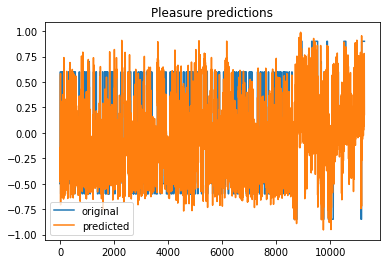

In [51]:
x_ax = range(len(test_y_p))
plt.plot(x_ax, test_y_p, label="original")
plt.plot(x_ax, pred_y_p, label="predicted")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

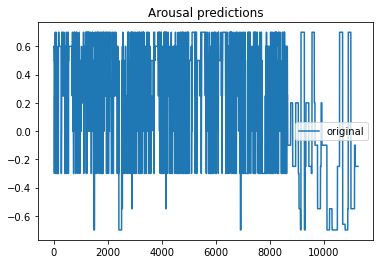

In [52]:
x_ax = range(len(test_y_a))
plt.plot(x_ax, test_y_a, label="original")

plt.title("Arousal predictions")

plt.legend()
plt.show()

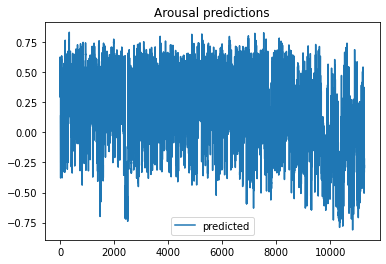

In [53]:
x_ax = range(len(test_y_a))
plt.plot(x_ax, pred_y_a, label="predicted")

plt.title("Arousal predictions")

plt.legend()
plt.show()

### Prediction

In [67]:
row=test_X.iloc[0]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[0]))
print('Predicted: %s' % [y_p[0], y_a[0]])

Real: [-0.5  0.6]
Predicted: [-0.29030004, 0.4199877]


In [71]:
row=test_X.iloc[420]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[420]))
print('Predicted: %s' % [y_p[0], y_a[0]])

Real: [-0.6 -0.3]
Predicted: [-0.36928195, -0.17541961]


In [69]:
row=test_X.iloc[4000]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[4000]))
print('Predicted: %s' % [y_p[0], y_a[0]])

Real: [-0.4   0.25]
Predicted: [-0.38055393, 0.20550194]
